In [1]:
!apt-get install -y libosmesa6-dev patchelf
!pip install gymnasium[mujoco] imageio[ffmpeg] pyopengl glfw -qU

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libosmesa6 libpciaccess-dev mesa-common-dev
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglx-dev libosmesa6 libosmesa6-dev libpciaccess-dev
  mesa-common-dev patchelf
0 upgraded, 8 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,833 kB of archives.
After this operation, 18.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64

In [2]:
import os
os.environ["MUJOCO_GL"] = "egl"
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import glob
import time
from google.colab import files
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [3]:
def make_env(env_id, seed, idx, capture_video, xml=None):
    def thunk():
        if xml is not None:
          if capture_video and idx == 0:
              env = gym.make(env_id, xml_file=xml , render_mode="rgb_array")
          else:
              env = gym.make(env_id, xml_file=xml)
        else:
          if capture_video and idx == 0:
              env = gym.make(env_id, render_mode="rgb_array")
          else:
              env = gym.make(env_id)

        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env

    return thunk


LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))

        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (env.single_action_space.high - env.single_action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (env.single_action_space.high + env.single_action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

In [4]:
from gymnasium.envs.mujoco.ant_v5 import AntEnv
from gymnasium.spaces import Box
from gymnasium.envs.registration import register

class ThreeLegAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.action_space = Box(low=-1.0, high=1.0, shape=(6,), dtype=np.float32)

register(
    id="3LegAnt",
    entry_point=ThreeLegAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class FiveLegAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.action_space = Box(low=-1.0, high=1.0, shape=(10,), dtype=np.float32)

register(
    id="5LegAnt",
    entry_point=FiveLegAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class HopperAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

register(
    id="HopperAnt",
    entry_point=HopperAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class LongShortAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

register(
    id="LongShortAnt",
    entry_point=LongShortAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class ShortLongAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

register(
    id="ShortLongAnt",
    entry_point=ShortLongAntEnv,
    max_episode_steps=1000,
    reward_threshold=6000.0,
)

class ClimberAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self._forward_reward_weight = 0.3
    self._healthy_z_range = (0.2, 1.6)
  def _get_rew(self, x_velocity: float, action):
      to_x_reward = 0
      if x_velocity > 0.3:
        to_x_reward = 2
      forward_reward = (x_velocity * self._forward_reward_weight) + to_x_reward
      healthy_reward = self.healthy_reward
      rewards = forward_reward + healthy_reward

      ctrl_cost = self.control_cost(action)
      contact_cost = self.contact_cost
      costs = ctrl_cost + contact_cost

      reward = rewards - costs

      reward_info = {
          "reward_forward": forward_reward,
          "reward_ctrl": -ctrl_cost,
          "reward_contact": -contact_cost,
          "reward_survive": healthy_reward,
      }

      return reward, reward_info

register(
    id="ClimberAnt",
    entry_point=ClimberAntEnv,
    max_episode_steps=1200,
    reward_threshold=5000.0,
)

class GoAroundAntEnv(AntEnv):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self._forward_reward_weight = 0.3
  def _get_rew(self, x_velocity: float, action):
      to_x_reward = 0
      if x_velocity > 0.3:
        to_x_reward = 2
      forward_reward = (x_velocity * self._forward_reward_weight) + to_x_reward
      healthy_reward = self.healthy_reward
      rewards = forward_reward + healthy_reward

      ctrl_cost = self.control_cost(action)
      contact_cost = self.contact_cost
      costs = ctrl_cost + contact_cost

      reward = rewards - costs

      reward_info = {
          "reward_forward": forward_reward,
          "reward_ctrl": -ctrl_cost,
          "reward_contact": -contact_cost,
          "reward_survive": healthy_reward,
      }

      return reward, reward_info


register(
    id="GoAroundAnt",
    entry_point=GoAroundAntEnv,
    max_episode_steps=1200,
    reward_threshold=5000.0,
)

In [5]:
def evaluate( model_path: str, env_id: str, eval_episodes: int,
              device: torch.device = torch.device("cpu"),
              seed = 0,
              env_xml = None,
            ):

    envs = gym.vector.SyncVectorEnv([make_env(env_id, seed, 0, capture_video=False, xml=env_xml)])
    actor = Actor(envs).to(device)
    if model_path is not None:
      actor.load_state_dict(torch.load(model_path, map_location=device))
    actor.eval()

    obs, _ = envs.reset()

    episode_return = np.zeros(1, dtype=np.float32)
    episodic_returns = []
    while len(episodic_returns) < eval_episodes:
        actions, _, _ = actor.get_action(torch.Tensor(obs).to(device))
        obs, rewards, done, truncated, _ = envs.step(actions.detach().cpu().numpy())
        dones = np.logical_or(done, truncated)
        episode_return += rewards
        if dones.any():
          episodic_returns.append(episode_return)
          episode_return = 0.0

    return episodic_returns

def compute_stats(returns):
    mean = np.mean(returns)
    std = np.std(returns)
    print(f"Mean: {mean}, Std: {std}")
    return mean, std

def plot_grouped_barcharts(results):
    base_mean, base_std = results["BaseAnt"]["BaseAnt"]
    untrained_mean, untrained_std = results["BaseAnt"]["Untrained"]

    for variant, data in results.items():
        if variant == "BaseAnt":
            continue  # Skip base-only

        labels = []
        means = []
        stds = []

        # Add base references
        labels.append("Untrained")
        means.append(untrained_mean)
        stds.append(untrained_std)

        labels.append("Base")
        means.append(base_mean)
        stds.append(base_std)

        # Add variant-specific entries
        for label in data:
            mean, std = data[label]
            labels.append(label)
            means.append(mean)
            stds.append(std)

        # Plot
        plt.figure(figsize=(8, 5))
        # bar_count = len(labels)
        # x = np.linspace(0, bar_count - 1, bar_count) *0.7
        x = np.arange(len(labels)) * 0.25
        bars = plt.bar(x, means, yerr=stds, capsize=5, width=0.2)
        plt.xticks(x, labels, rotation=30, ha="right")
        plt.ylabel("Mean & Std Episodic Returns")
        plt.title(f"Evaluation Results for {variant}")
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        import matplotlib.patches as mpatches
        import matplotlib.lines as mlines

        bar_patch = mpatches.Patch(color=bars[0].get_facecolor(), label='Mean Return')
        error_line = mlines.Line2D([], [], color='black', marker='_', linestyle='None',
                                   markersize=10, label='± 1 Std Dev')

        plt.legend(handles=[bar_patch, error_line], loc='upper left', fontsize=9)

        filename = f"{variant}_results.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

        files.download(filename)

Mean: 717.1237033397136, Std: 107.30097332591417
Mean: 5488.206795436365, Std: 997.0443284019071
Mean: -223.18848672173576, Std: 537.661513074442
Mean: 2853.7771055872345, Std: 1355.2987282918896
Mean: 2917.7101076637246, Std: 1414.7488547277069
Mean: 3886.9787875373922, Std: 1596.7395100465542
Mean: 4281.779775070683, Std: 810.4663596619283


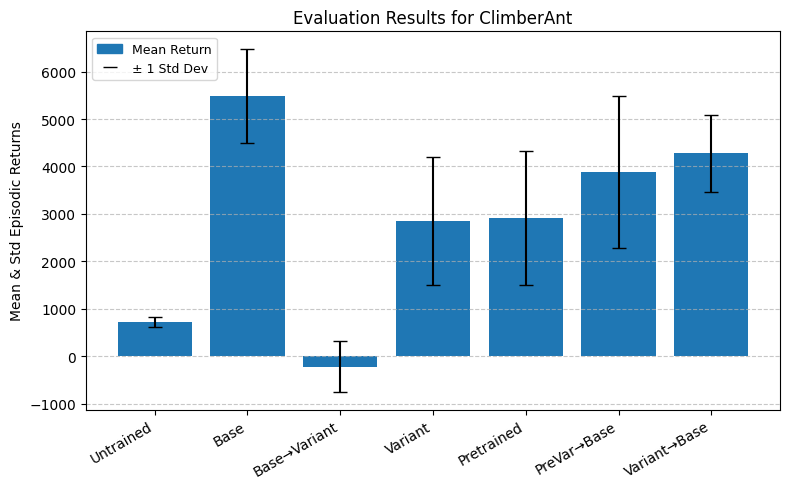

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
#Ants
BaseAnt="Ant-v5"
BaseAnt_model="/content/1_Ant_ExpBase_SAC_actor.pth"

ClimberAnt = "ClimberAnt"
ClimberAnt_xml="/content/ClimberAnt.xml"
Climber_model="/content/1_Climber_Base_1_actor.pth"
Pretrain_Climber_model="/content/None_Climber_EXP_1_actor.pth"

HopperAnt = "HopperAnt"
HopperAnt_xml="/content/HopperAnt.xml"
Hopper_model1="/content/1_Hopper_Base_1_actor.pth"
Hopper_model2="/content/2_Hopper_Base_2_actor.pth"
Pretrain_Hopper_model1="/content/1_Hopper_EXP_1_actor.pth"
Pretrain_Hopper_model2="/content/2_Hopper_EXP_2_actor.pth"

ShortLongAnt = "ShortLongAnt"
ShortLongAnt_xml="/content/ShortLongAnt.xml"
ShortLong_model="/content/1_ShortLong_Base_1_actor.pth"
Pretrain_ShortLong_model="/content/1_ShortLong_EXP_1_actor.pth"

GoAroundAnt = "GoAroundAnt"
GoAroundAnt_xml="/content/GoAroundAnt.xml"
GoAround_model="/content/1_GoAround_Base_1_actor.pth"
Pretrain_GoAround_model="/content/1_GoAround_EXP_1_actor.pth"



episodes=100



#0) What is the performance of an untrained model?
#1) How well does the BaseAnt model perform?
#For each Ant variant (to moddels in case of HopperAnt, best and worst performers)
#2) How well does the BaseAnt model perform on the variant env?
#3) How well does does the varient model perform?
#4) How well does the pretrained varient model perform?
#5) How well does the pretrained varient model perform on the Ant-v5 env? Knowledge Perserved?
#6) How well doed the varient model perform on the Ant-v5 env? Knowledge Perserved?

'''Untrained model run on BaseAnt Env'''
Untrained_returns = evaluate(model_path=None, env_id=BaseAnt, eval_episodes=episodes)
'''BaseAnt model Eval'''
BaseAnt_returns = evaluate(model_path=BaseAnt_model, env_id=BaseAnt, eval_episodes=episodes)

#Climber
'''BaseAnt model run on ClimberAnt Env''' #Base->Climber
BaseToClimber_returns = evaluate(model_path=BaseAnt_model, env_id=ClimberAnt, eval_episodes=episodes, env_xml=ClimberAnt_xml)
'''ClimberAnt model Eval''' #Climber Eval
ClimberAnt_returns = evaluate(model_path=Climber_model, env_id=ClimberAnt, eval_episodes=episodes, env_xml=ClimberAnt_xml)
'''Pretrained ClimberAnt model Eval''' #Pretrained_Climber Eval
Pretrain_ClimberAnt_returns = evaluate(model_path=Pretrain_Climber_model, env_id=ClimberAnt, eval_episodes=episodes, env_xml=ClimberAnt_xml)
'''Pretrained ClimberAnt model run on BaseAnt Env''' #Pretrained_Climber->Base
Pretrain_ClimberToBase_returns = evaluate(model_path=Pretrain_Climber_model, env_id=BaseAnt, eval_episodes=episodes)
'''ClimberAnt model run on BaseAnt Env''' #Climber->Base
ClimberToBase_returns = evaluate(model_path=Climber_model, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "ClimberAnt": {
        "Base→Variant": compute_stats(BaseToClimber_returns),
        "Variant": compute_stats(ClimberAnt_returns),
        "Pretrained": compute_stats(Pretrain_ClimberAnt_returns),
        "PreVar→Base": compute_stats(Pretrain_ClimberToBase_returns),
        "Variant→Base": compute_stats(ClimberToBase_returns),
    }
}

plot_grouped_barcharts(results)

Mean: 717.1237033397136, Std: 107.30097332591417
Mean: 5488.206795436365, Std: 997.0443284019071
Mean: -127.4184303573391, Std: 311.0513068050611
Mean: 2774.699182108577, Std: 852.6908735286792
Mean: 3127.981219746062, Std: 779.7031039898535
Mean: 3301.876124844841, Std: 951.6289903380053
Mean: 926.6714503638439, Std: 13.518370989681431
Mean: 39.141023409224566, Std: 130.1950028831803
Mean: 545.982978735511, Std: 9.2508747990511
Mean: 51.48012330739272, Std: 148.16517927016542
Mean: -990.0155417565635, Std: 334.23017164261216


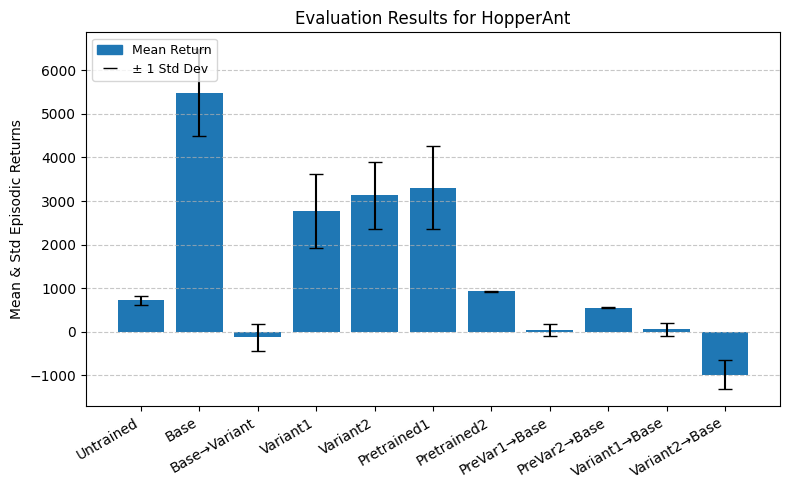

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#Hopper best and worst models.
'''BaseAnt model run on HopperAnt Env'''
BaseToHopper_returns = evaluate(model_path=BaseAnt_model, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''HopperAnt model1 Eval'''
HopperAnt1_returns = evaluate(model_path=Hopper_model1, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''HopperAnt model2 Eval'''
HopperAnt2_returns = evaluate(model_path=Hopper_model2, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''Pretrained HopperAnt model1 Eval'''
Pretrain_HopperAnt1_returns = evaluate(model_path=Pretrain_Hopper_model1, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''Pretrained HopperAnt model2 Eval'''
Pretrain_HopperAnt2_returns = evaluate(model_path=Pretrain_Hopper_model2, env_id=HopperAnt, eval_episodes=episodes, env_xml=HopperAnt_xml)
'''Pretrained HopperAnt model1 run on BaseAnt Env'''
PreHopToBase1_returns = evaluate(model_path=Pretrain_Hopper_model1, env_id=HopperAnt, eval_episodes=episodes)
'''Pretrained HopperAnt model2 run on BaseAnt Env'''
PreHopToBase2_returns = evaluate(model_path=Pretrain_Hopper_model2, env_id=HopperAnt, eval_episodes=episodes)
'''HopperAnt model1 run on BaseAnt Env'''
HopToBase1_returns = evaluate(model_path=Hopper_model1, env_id=BaseAnt, eval_episodes=episodes)
'''HopperAnt model2 run on BaseAnt Env'''
HopToBase2_returns = evaluate(model_path=Hopper_model2, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "HopperAnt": {
        "Base→Variant": compute_stats(BaseToHopper_returns),
        "Variant1": compute_stats(HopperAnt1_returns),
        "Variant2": compute_stats(HopperAnt2_returns),
        "Pretrained1": compute_stats(Pretrain_HopperAnt1_returns),
        "Pretrained2": compute_stats(Pretrain_HopperAnt2_returns),
        "PreVar1→Base": compute_stats(PreHopToBase1_returns),
        "PreVar2→Base": compute_stats(PreHopToBase2_returns),
        "Variant1→Base": compute_stats(HopToBase1_returns),
        "Variant2→Base": compute_stats(HopToBase2_returns),
    }
}

plot_grouped_barcharts(results)

Mean: 717.1237033397136, Std: 107.30097332591417
Mean: 5488.206795436365, Std: 997.0443284019071
Mean: -261.5932884562293, Std: 839.017522336776
Mean: 2669.6485791110968, Std: 1036.550162975226
Mean: 2050.7497599536514, Std: 1415.8426599944996
Mean: 3826.862418019624, Std: 427.0184812212071
Mean: 3032.8685948312927, Std: 241.19685127367103


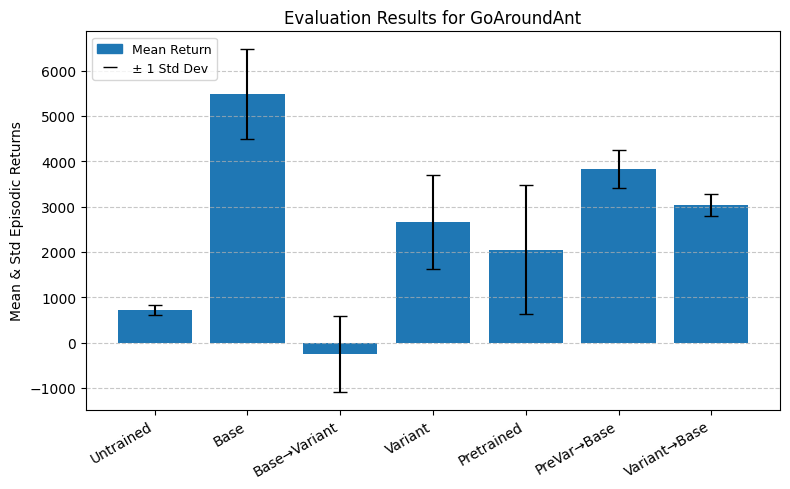

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
#GoAround
'''BaseAnt model run on GoAroundAnt Env'''
BaseToGoAround_returns = evaluate(model_path=BaseAnt_model, env_id=GoAroundAnt, eval_episodes=episodes, env_xml=GoAroundAnt_xml)
'''GoAroundAnt model Eval'''
GoAroundAnt_returns = evaluate(model_path=GoAround_model, env_id=GoAroundAnt, eval_episodes=episodes, env_xml=GoAroundAnt_xml)
'''Pretrained GoAroundAnt model Eval'''
Pretrain_GoAroundAnt_returns = evaluate(model_path=Pretrain_GoAround_model, env_id=GoAroundAnt, eval_episodes=episodes, env_xml=GoAroundAnt_xml)
'''Pretrained GoAroundAnt model run on BaseAnt Env'''
PreGoAroundToBase_returns = evaluate(model_path=Pretrain_GoAround_model, env_id=BaseAnt, eval_episodes=episodes)
'''GoAroundAnt model run on BaseAnt Env'''
GoAroundToBase_returns = evaluate(model_path=GoAround_model, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "GoAroundAnt": {
        "Base→Variant": compute_stats(BaseToGoAround_returns),
        "Variant": compute_stats(GoAroundAnt_returns),
        "Pretrained": compute_stats(Pretrain_GoAroundAnt_returns),
        "PreVar→Base": compute_stats(PreGoAroundToBase_returns),
        "Variant→Base": compute_stats(GoAroundToBase_returns),
    }
}

plot_grouped_barcharts(results)

Mean: 717.1237033397136, Std: 107.30097332591417
Mean: 5488.206795436365, Std: 997.0443284019071
Mean: 576.7434036060465, Std: 472.5673177883781
Mean: 3446.6796154413964, Std: 1200.1579146179417
Mean: 4455.660351453996, Std: 1426.8744163851916
Mean: 3824.6371604681412, Std: 1009.1781627437676
Mean: 2442.7575856178214, Std: 873.0778673114643


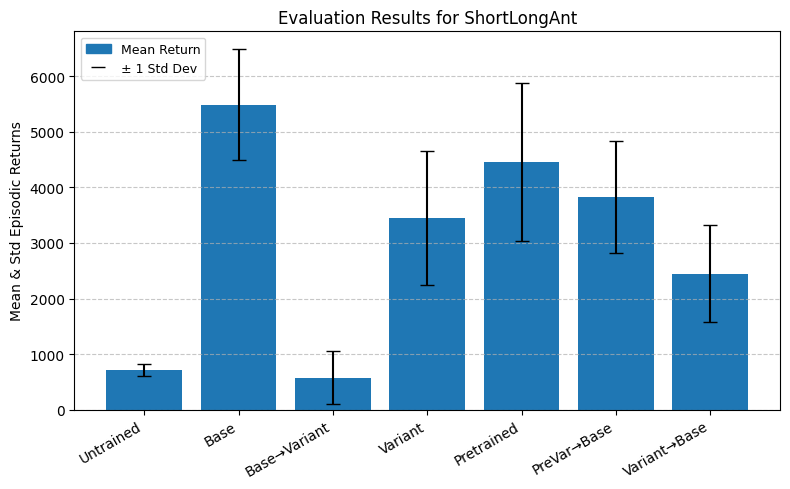

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#ShortLong
'''BaseAnt model run on ShortLongAnt Env'''
BaseToShortLong_returns = evaluate(model_path=BaseAnt_model, env_id=ShortLongAnt, eval_episodes=episodes, env_xml=ShortLongAnt_xml)
'''ShortLongAnt model Eval'''
ShortLongAnt_returns = evaluate(model_path=ShortLong_model, env_id=ShortLongAnt, eval_episodes=episodes, env_xml=ShortLongAnt_xml)
'''Pretrained ShortLongAnt model Eval'''
Pretrain_ShortLongAnt_returns = evaluate(model_path=Pretrain_ShortLong_model, env_id=ShortLongAnt, eval_episodes=episodes, env_xml=ShortLongAnt_xml)
'''Pretrained ShortLongAnt model run on BaseAnt Env'''
PreShortLongToBase_returns = evaluate(model_path=Pretrain_ShortLong_model, env_id=BaseAnt, eval_episodes=episodes)
'''ShortLongAnt model run on BaseAnt Env'''
ShortLongToBase_returns = evaluate(model_path=ShortLong_model, env_id=BaseAnt, eval_episodes=episodes)

results = {
    "BaseAnt": {
        "Untrained": compute_stats(Untrained_returns),
        "BaseAnt": compute_stats(BaseAnt_returns),
    },
    "ShortLongAnt": {
        "Base→Variant": compute_stats(BaseToShortLong_returns),
        "Variant": compute_stats(ShortLongAnt_returns),
        "Pretrained": compute_stats(Pretrain_ShortLongAnt_returns),
        "PreVar→Base": compute_stats(PreShortLongToBase_returns),
        "Variant→Base": compute_stats(ShortLongToBase_returns),
    }
}

plot_grouped_barcharts(results)